In [1]:
import healpy as hp
import xarray as xr
import xdggs


import fsspec
import sparse
import matplotlib.pyplot as plt

In [2]:
fs = fsspec.filesystem("http")
#ds=xr.open_zarr('https://data-taos.ifremer.fr/GRID4EARTH/Sentinel2_test.zarr').pipe(xdggs.decode)
ds=xr.open_zarr('/mnt/d/testh.zarr').dggs.decode()
ds

<xarray.Dataset> Size: 12GB
Dimensions:    (time: 88, bands: 4, cell_ids: 4194304)
Coordinates:
  * bands      (bands) <U3 48B 'b02' 'b03' 'b04' 'b08'
  * cell_ids   (cell_ids) int64 34MB 3175086030672 ... 3175134953519
  * time       (time) datetime64[ns] 704B 2018-06-01T10:20:21 ... 2022-08-12T...
Data variables:
    Sentinel2  (time, bands, cell_ids) float64 12GB dask.array<chunksize=(1, 4, 4194304), meta=np.ndarray>
Indexes:
    cell_ids  HealpixIndex(level=21, indexing_scheme=nested)

In [3]:
ds.Sentinel2.isel(time=2).compute().dggs.explore(cmap='coolwarm')

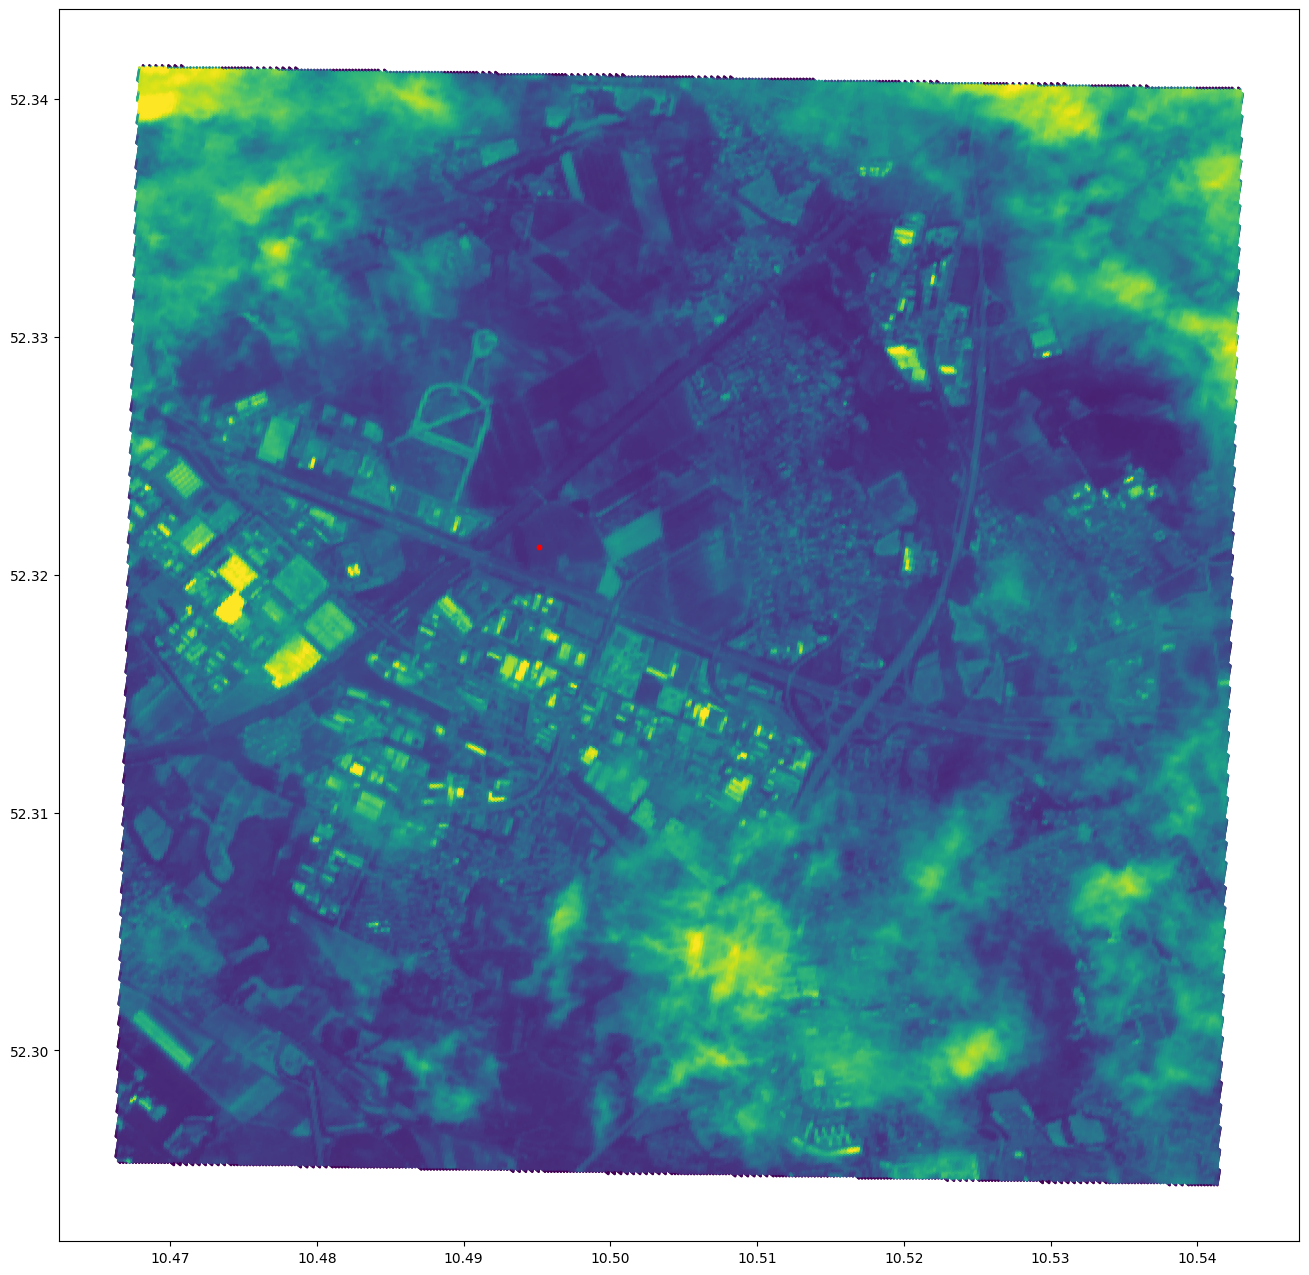

In [4]:
cell_ids=3175132527640
ph_r,th_r=hp.pix2ang(2**21,cell_ids,lonlat=True,nest=True)

ph,th=hp.pix2ang(2**21,ds.cell_ids.values,lonlat=True,nest=True)
plt.figure(figsize=(16,16))
plt.scatter(ph,th,c=ds.Sentinel2.sel(bands='b04').isel(time=0).compute().values,s=0.5,vmin=1000,vmax=6000)
plt.scatter(ph_r,th_r,color='r',s=100)

Text(0.5, 0, 'Date')

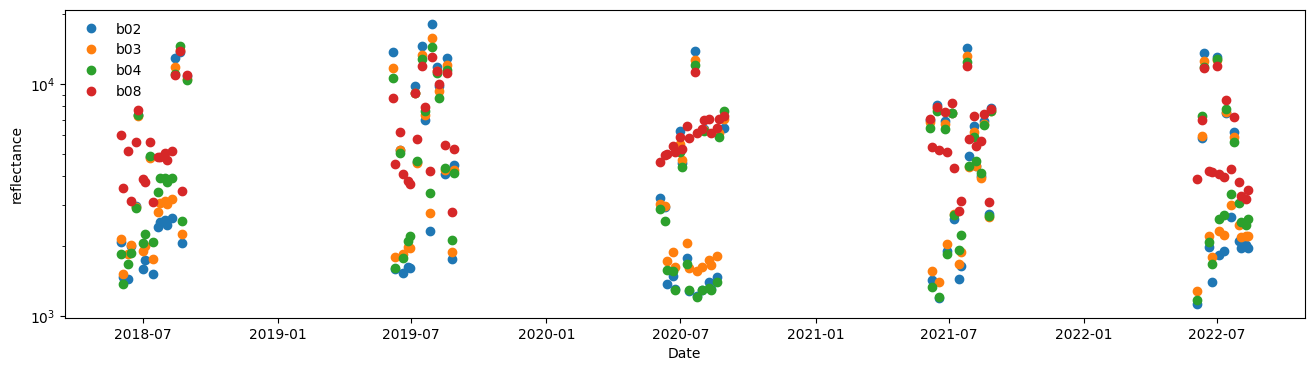

In [5]:
band=list(ds.bands.values)
plt.figure(figsize=(16,4))
for k in band:
    plt.plot(ds.time.values,ds.Sentinel2.sel(bands=k).sel(cell_ids=3175132527640).compute().values,'o',label=k)
plt.legend(frameon=0)
plt.yscale('log')
plt.ylabel('reflectance')
plt.xlabel('Date')

In [6]:
import foscat.scat_cov as sc
f=sc.funct(BACKEND='torch')

262144
10.504665305807773 52.317869862498


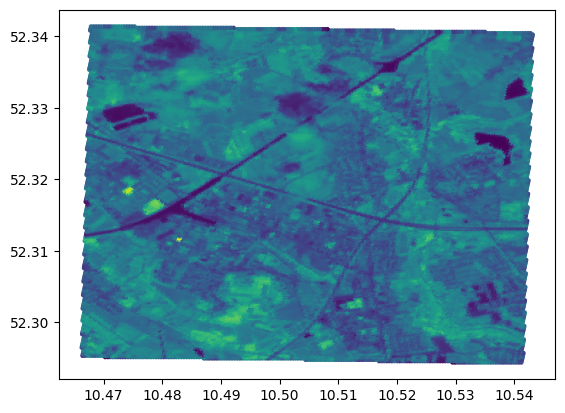

In [7]:

import numpy as np
import matplotlib.pyplot as plt

d=ds.Sentinel2.sel(bands='b08').isel(time=2).compute()
data=d.values
data-=data.mean()
cell=d.cell_ids.values
cell
nside=2**20
im,c2=f.ud_grade_2(f.backend.bk_cast(data),cell_ids=cell,nside=2**19)
for k in range(2):
    im,c2=f.ud_grade_2(im,cell_ids=c2,nside=2**(18-k))
    nside//=2

print(nside)
th,ph=hp.pix2ang(nside,c2.cpu().numpy(),lonlat=True,nest=True)
print(th.mean(),ph.mean())

plt.scatter(th,ph,c=im.cpu().numpy(),s=5)

/home/jmdeloui/miniconda3/envs/py311/lib/python3.11/site-packages/foscat/BkTorch.py:152: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  return self.backend.sparse_coo_tensor(indice.T, w, dense_shape).to_sparse_csr().to(self.torch_device)


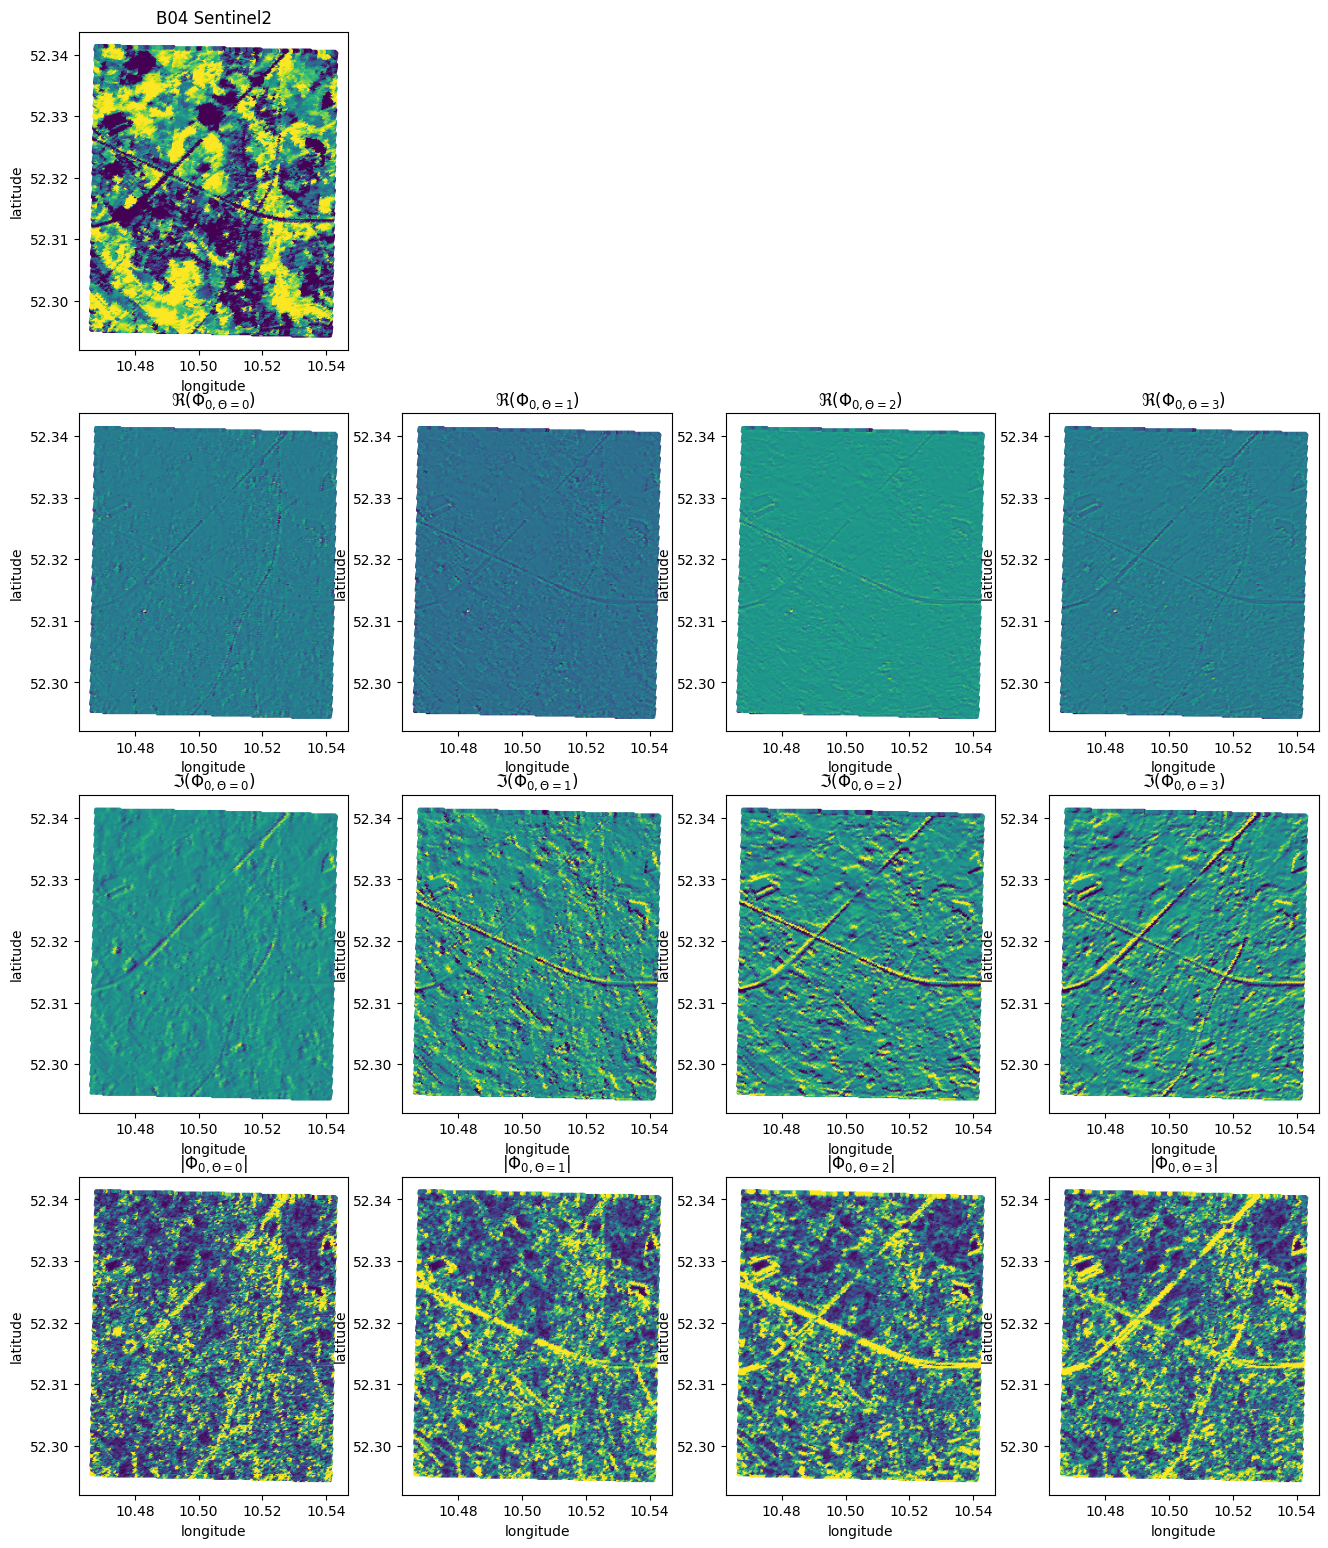

In [8]:
sim=f.convol(im,cell_ids=c2,nside=nside)
c2=c2.cpu().numpy()

plt.figure(figsize=(16,19))
amp=1000
cmap='viridis'
plt.subplot(4,4,1)
plt.title(r'B04 Sentinel2')
plt.scatter(th,ph,c=np.clip(im.cpu().numpy(),-amp,amp),s=5,cmap=cmap)
plt.ylabel('latitude')
plt.xlabel('longitude')
amp=300
for k in range(4):
    plt.subplot(4,4,5+k)
    plt.title(r'$\Re(\Phi_{0,\Theta=%d})$'%(k))
    plt.scatter(th,ph,c=np.clip(sim[k].cpu().numpy().real,-amp*10,amp*10),s=3,cmap=cmap)
    plt.ylabel('latitude')
    plt.xlabel('longitude')
    plt.subplot(4,4,9+k)
    plt.title(r'$\Im(\Phi_{0,\Theta=%d})$'%(k))
    plt.scatter(th,ph,c=np.clip(sim[k].cpu().numpy().imag,-amp,amp),s=3,cmap=cmap)
    plt.ylabel('latitude')
    plt.xlabel('longitude')
    plt.subplot(4,4,13+k)
    plt.title(r'$|\Phi_{0,\Theta=%d}|$'%(k))
    plt.scatter(th,ph,c=np.clip(abs(sim[k].cpu().numpy()),0,amp),s=3,cmap=cmap)
    plt.ylabel('latitude')
    plt.xlabel('longitude')